In [1]:
import os
from tempfile import NamedTemporaryFile
from dotenv import load_dotenv

import pandas as pd
from IPython.display import display


from crawler.collector import collect_links
from parsers.books_tocrape import parse_item, is_category
from utils.s3 import AsyncObjectStorage

In [2]:
load_dotenv()
storage = AsyncObjectStorage(
    key_id=os.getenv("AWS_ACCESS_KEY_ID"),
    secret=os.getenv("AWS_SECRET_ACCESS_KEY"),
    endpoint=os.getenv("AWS_ENDPOINT"),
    bucket=os.getenv("AWS_BUCKET"),
)

start_url = "https://books.toscrape.com/"


## 1) Сбор URL

In [3]:
all_urls = collect_links(start_url, max_pages=3)
len(all_urls)

75

## 2) Фильтрация: оставляем карточки товара

In [4]:
cat_prefix = "https://books.toscrape.com/catalogue/category/"

# фильтруем все что попало под маску категорий
catgory_list = set(filter(lambda url: is_category(cat_prefix, url), all_urls))

item_urls = list(all_urls.difference(catgory_list, {start_url}))

print("было собрано", len(all_urls), "url")
print("из них карточек товаров", len(item_urls))

было собрано 75 url
из них карточек товаров 22


## 3) Парсинг значений по карточкам

In [5]:
fields = [
    "product_name",
    "price_amount",
    "price_currency",
    "breadcrumbs",
    "instock_text",
    "instock_qty",
]
results = []
for url in item_urls:
    data = parse_item(url, fields=fields)
    if data:
        results.append(data)


## 4) DataFrame и выгрузка в S3

In [7]:
df = pd.DataFrame(results)
print("Получено", df.shape)

df = df.dropna()
print("Осталось после очистки", df.shape)

df.head()

Получено (22, 7)
Осталось после очистки (20, 7)


,product_name,price_amount,price_currency,breadcrumbs,instock_text,instock_qty,url
0,The Requiem Red,22.65,£,Home > Books > Young Adult,In stock (19 available),19.0,https://books.toscrape.com/catalogue/the-requi...
1,Soumission,50.10,£,Home > Books > Fiction,In stock (20 available),20.0,https://books.toscrape.com/catalogue/soumissio...
2,Scott Pilgrim's Precious Little Life (Scott Pi...,52.29,£,Home > Books > Sequential Art,In stock (19 available),19.0,https://books.toscrape.com/catalogue/scott-pil...
3,The Dirty Little Secrets of Getting Your Dream...,33.34,£,Home > Books > Business,In stock (19 available),19.0,https://books.toscrape.com/catalogue/the-dirty...
4,Our Band Could Be Your Life: Scenes from the A...,57.25,£,Home > Books > Music,In stock (19 available),19.0,https://books.toscrape.com/catalogue/our-band-...


In [8]:
if df.empty:
    print("DataFrame пуст — ничего не выгружаю в S3")
    s3_key = None
else:
    with NamedTemporaryFile(delete=True, suffix=".csv") as tmp:
        df.to_csv(tmp.name, index=False)
        s3_key = f"parser_csv/{os.path.basename(tmp.name)}"
        await storage.send_file(tmp.name, s3_key)
    print("Uploaded to s3:", s3_key)


Uploaded to s3: parser_csv/tmpryz6dx48.csv


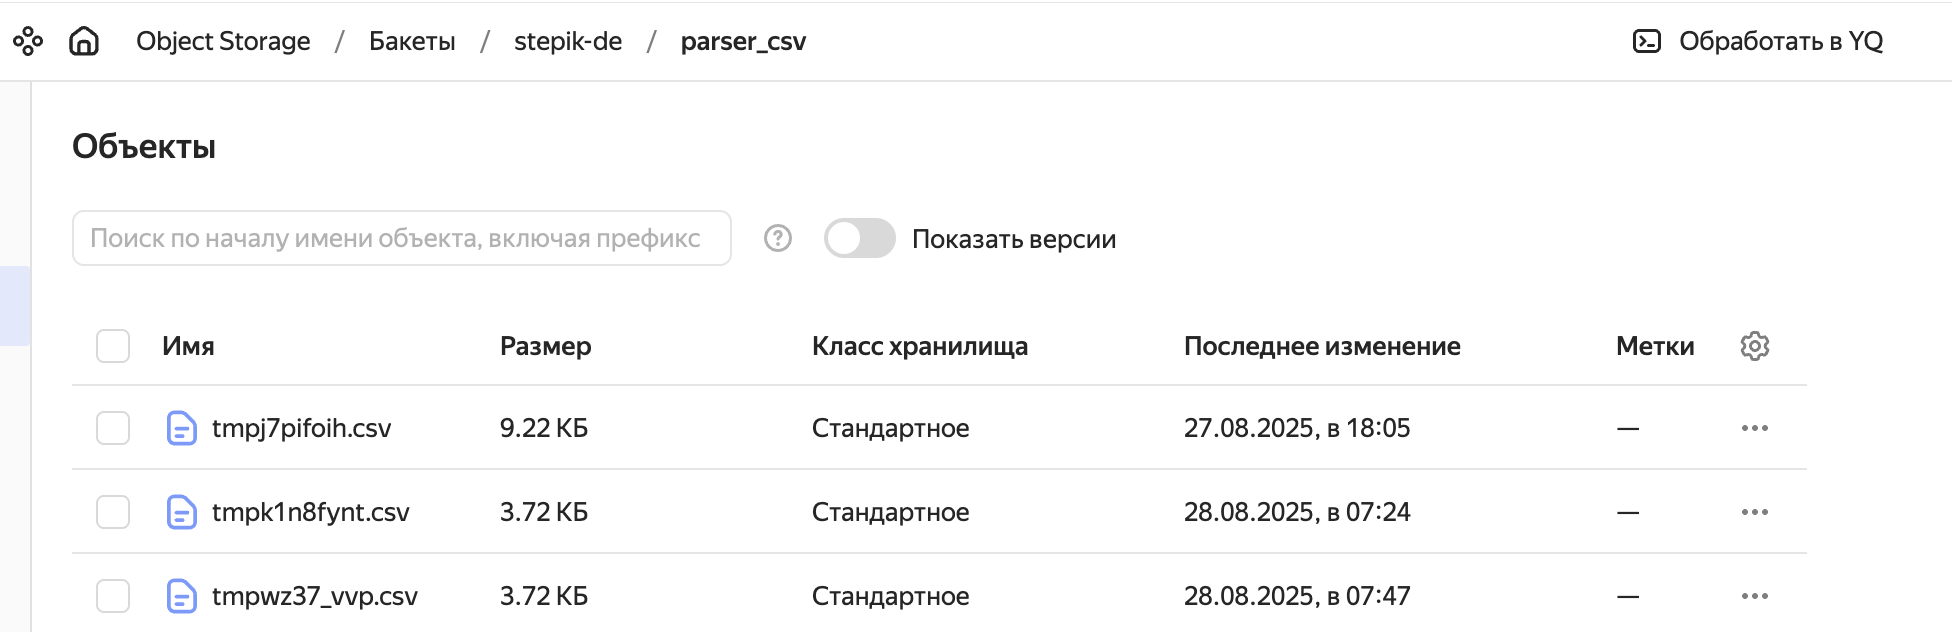

In [15]:
from IPython.display import Image, display

# Показать изображение из файла
img = Image(filename='img/image.png', width=800)
display(img)